In [216]:
%matplotlib inline
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from scipy.special import erfc
import healpy as H

In [116]:
dirname = 'icecube_10year_ps/events/'
filenames = ['IC86_I_exp.csv','IC86_III_exp.csv','IC86_IV_exp.csv',\
             'IC86_V_exp.csv','IC86_VI_exp.csv','IC86_VII_exp.csv']

RA = []
DEC = []
energy = []
lines = np.array([])

for filename in filenames:
    
    temp = np.array([line.strip() for line in open(dirname + filename)])
    lines = np.concatenate((lines,np.array([line.strip() for line in open(dirname + filename)])))
    
rows = np.array([row.split() for row in lines[1:]])

In [120]:
energy = np.array([np.float(element) for element in rows[:,1]])
RA = np.array([np.float(element) for element in rows[:,3]])
DEC = np.array([np.float(element) for element in rows[:,4]])

In [204]:
nside = 32
npix = H.nside2npix(nside)
eventmap = np.zeros(npix)

pixels = H.ang2pix(nside,np.pi/2-DEC/180.*np.pi,RA/180.*np.pi)

for i in range(0,len(pixels)) :
    eventmap[pixels[i]] += 1

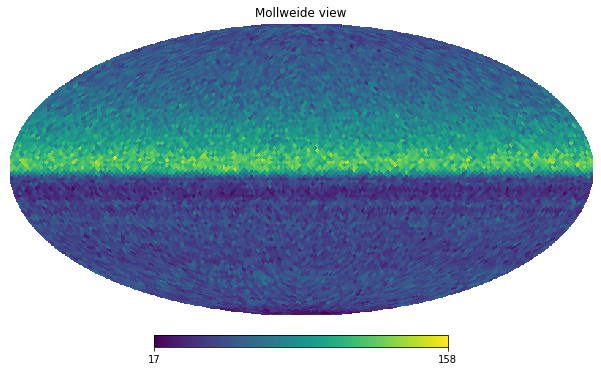

In [205]:
H.mollview(eventmap)

In [206]:
nsideHIGH = 1024
high_res_map = H.ud_grade(eventmap,nsideHIGH)
LMAX = 4*nsideHIGH

out  = H.anafast(high_res_map,alm=True,lmax=LMAX)
outBGR = np.zeros_like(out[1])

for i in range(0,LMAX+1) :
    
    index = H.sphtfunc.Alm.getidx(LMAX,i,0)
    outBGR[index] = out[1][index]

high_res_map = H.alm2map(outBGR,nsideHIGH,lmax=LMAX,verbose=False)

backgroundmap = H.ud_grade(high_res_map,nside)

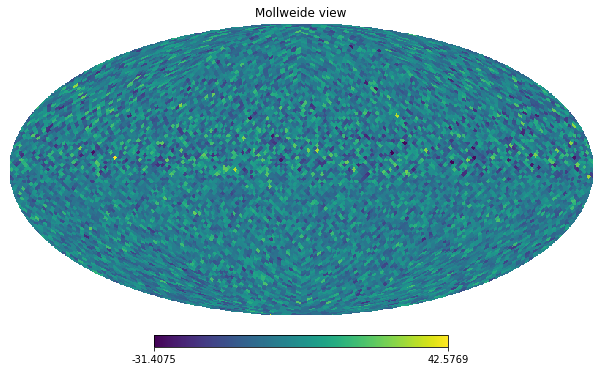

In [246]:
H.mollview(eventmap-backgroundmap)

In [202]:
totevents = np.sum(eventmap)
TSmap = np.zeros(npix)

for i in range(0,npix) :
    
    bestfit = (eventmap[i]*npix-totevents)/(npix-1)
    
    temp = 0.0
    if eventmap[i] > 0.0 :
          temp = -2*(eventmap[i]*np.log(backgroundmap[i]/eventmap[i])+eventmap[i]-backgroundmap[i])
    TSmap[i] = temp        

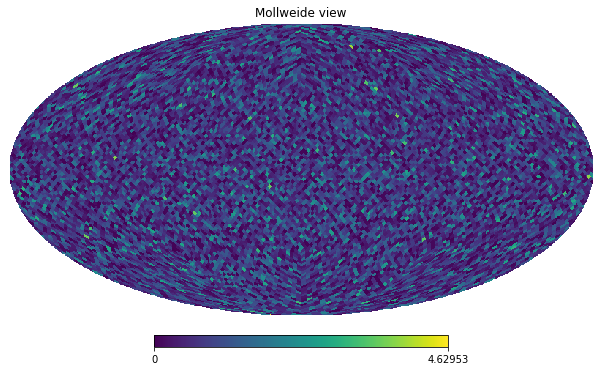

In [214]:
H.mollview(sqrt(TSmap),min=0)

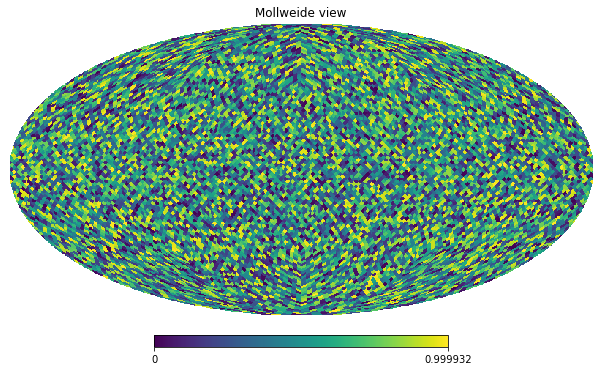

In [237]:
H.mollview(erfc(sqrt(TSmap/2)),min=0)

In [244]:
min(erfc(sqrt(TSmap/2)))*npix

0.04503588527581805

In [248]:
pvalues = sort(erfc(sqrt(TSmap/2)))

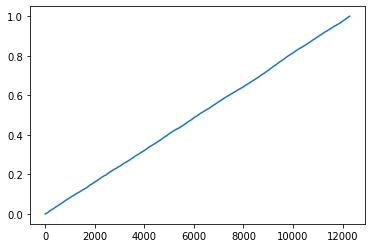

In [360]:
pvalues = sort(np.random.rand(npix))
plot(pvalues)

In [252]:
from scipy.special import binom

In [324]:
for i in range(1,1) :
    print(i)

In [396]:
Pk = [1-sum([binom(npix,k-1)*pvalues[kmax-1]**(k-1)*(1-pvalues[kmax-1])**(npix-k+1) for k in range(1,kmax+1)])\
      for kmax in range(1,150)]

In [408]:
Pk = [1-sum([binom(npix,k-1)*((kmax)/(npix))**(k-1)*(1-(kmax)/(npix))**(npix-k+1) for k in range(1,kmax+1)])\
      for kmax in range(1,150)]

In [401]:
Pk2 = [1-sum([binom(10*npix,k-1)*((kmax)/(10*npix))**(k-1)*(1-(kmax)/(10*npix))**(10*npix-k+1) for k in range(1,kmax+1)])\
      for kmax in range(1,150)]

/Users/mahlers/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [397]:
print((1-(1-pvalues[0])**npix),Pk[0])

0.7712422382598029 0.7712422382598029


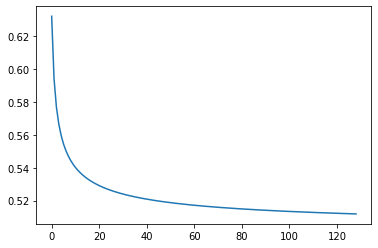

In [409]:
plot(Pk)

In [288]:
[1-sum(terms[:k]) for k in range(1,140)]

0.5441911306863552